In [568]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
plt.style.use(plt_styles[7])


In [569]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]
    

In [570]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [571]:
n_problem = int(input(f"Elige el problema (1-{len(inPaths)}): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [572]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [573]:
toolbox = base.Toolbox()

In [574]:
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)


In [575]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [576]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [577]:


def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, _ = ride
        origin = [a, b]
        destiny = [x, y]

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for _, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness = calc_fitness(car_rides)
            fitness += _fitness

    return fitness,


In [578]:
TOURNSIZE = 3
INDPB = 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [579]:
NIND = 300

pop = toolbox.population(n=NIND)


In [580]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")


Individuo
[18, 68, 97, 76, 26, 22, 87, 97, 45, 40, 16, 97, 49, 22, 11, 66, 0, 74, 97]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (164183.0,)


In [581]:
def get_penalty(ind):
    pen = 0

    for i_ride, i_car in enumerate(ind):
        adapted_ride = rides[i_ride][-1]
        adapted_car = adapted[i_car]

        if adapted_car == 0 and adapted_ride == 1:
            pen += 1

    return pen


def distance(ind):   
    def constant(pen): return pen
    def lineal(pen): return pen*2
    def quadratic(pen): return pen**2

    pen = get_penalty(ind)
    dis = lineal(pen)
    return dis


def feasible(ind):
    pen = get_penalty(ind)
    threshold = B  # Bonus value of problem.
    return -threshold <= pen <= threshold


![Constraints](https://deap.readthedocs.io/en/master/_images/constraints.png)

In [582]:
DISTANCE_OFFSET = 0

toolbox.decorate("evaluate", tools.DeltaPenality(
    feasible, DISTANCE_OFFSET, distance))


In [583]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
stats.register("avg", np.average)


In [584]:
NGEN = 50
CXPB = 0.8
MUTPB = 0.1

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

In [585]:
best_sol = tools.selBest(pop, k=1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)}")


El resultado de la evolución es:
gen	nevals	min 	max   	std    	avg     
0  	300   	-160	-104  	8.55023	-134.347
1  	246   	-148	-104  	7.50233	-126.78 
2  	257   	-138	-100  	6.88786	-120.193
3  	262   	-136	-92   	6.9729 	-115.407
4  	241   	-130	-88   	6.98357	-110.42 
5  	248   	-124	-90   	6.80776	-105.12 
6  	263   	-126	-86   	5.98821	-100.273
7  	256   	-120	-80   	5.61498	-96.4067
8  	262   	-114	-80   	5.54904	-92.8533
9  	239   	-110	-78   	5.37621	-89.42  
10 	243   	-102	-68   	4.735  	-85.92  
11 	250   	-108	-68   	5.07716	-82.68  
12 	242   	-108	-66   	5.17815	-79.9933
13 	240   	-104	-64   	5.8852 	-78.0667
14 	245   	-106	-64   	5.68592	-74.94  
15 	242   	-96 	-60   	6.15158	-72.2267
16 	257   	-92 	-56   	5.86083	-68.8067
17 	235   	-96 	-52   	5.55458	-65.6   
18 	227   	-94 	-54   	5.80032	-63.36  
19 	251   	-86 	-52   	5.60136	-61.2267
20 	235   	-90 	166193	16318.2	1581.29 
21 	248   	-90 	168064	37584.3	9152.15 
22 	253   	-88 	168064	57085.4	23290.9 
23 	238

Min pen: 175595.0


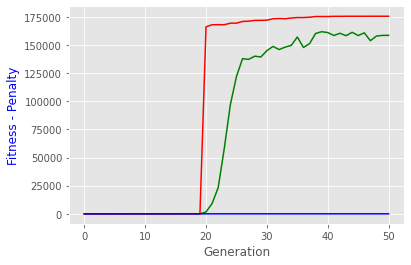

In [586]:
def plot_pen_fitness(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    maxs = lb.select("max")
    mins = lb.select("min")

    print(f"Min pen: {abs(max(maxs))}")

    _, ax = plt.subplots()

    ax.plot(gen, avgs, "g-", label="Average Fitness")
    ax.plot(gen, maxs, "r-", label="Average Fitness")
    ax.plot(gen, mins, "b-", label="Average Fitness")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness - Penalty", color="b")

    plt.show()


plot_pen_fitness(logbook)


In [587]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")